### 랭그래프 단계별 구축 과정
- https://www.langchain.com/ 의 공식문서 참고
- 파이썬 3.12.2

__step2_1 : Enhancing the Chatbot with Tools__
 - 챗봇 ai 모델에 도구를 붙여서 질문하기
 - 도구 : 웹 검색을 할 수 있는 Tavily 검색엔진

In [3]:
# 라이브러리 설치
%pip install -U tavily-python langchain_community # 검색엔진 사용을 위한 라이브러리

  Using cached tavily_python-0.5.1-py3-none-any.whl.metadata (91 kB)
  Using cached langchain_community-0.3.17-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain-0.3.18-py3-none-any.whl.metadata (7.8 kB)
  Using cached SQLAlchemy-2.0.38-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached aiohttp-3.11.12-cp313-cp313-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.7.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached aiohappyeyeballs-2.4.6-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.0 kB)
  Using cached propcache-0.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached 

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
import os
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [4]:
# 도구 정의하기
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3) # 최대 3개의 답변을 제공
tools = [tool]
tool.invoke("랭그래프에서 node가 뜻하는게 뭐야?")

[{'url': 'https://x2bee.tistory.com/430',
  'content': '이번에는 LangGraph의 핵심 요소 3가지(State, Node, Edge)가 어떻게 동작하는지 이해하고자 한다. LangGraph는 기본적으로 다양한 도구(정확하게는 Node)들의 연결된 집합으로 이해할 수 있다. from langgraph.graph.message import add_messages messages: Annotated[list, add_messages] from langgraph.graph import add_messages LangGraph에서는 이러한 방식을 통해 사용자와 LLM 간 메세지의 흐름을 관리하고 있다. from typing_extensions import Annotated, TypedDict setup: Annotated[str, ..., "The setup of the joke"] punchline: Annotated[str, ..., "The punchline of the joke"] messages: Annotated[list, add_messages] 여기서는 llm 이라는 노드에서 human_node 또는 next_node로 연결하도록 한다. \'A.I.(인공지능) & M.L.(머신러닝) > LLM\' 카테고리의 다른 글 A.I.(인공지능) & M.L.(머신러닝)/LLM 관련 글 langgraph #React #443 #LLM #Lora #nifi #Langchain #HuggingFace #fine-tuning #문제해결 #AWS EKS #rag #ElasticSearch #아파치 #nextjs #python #검색엔진 #finetuning #Spring Boot Batch #adapter_model.bin #파이썬 #venv #나이파이 #Ai #셀레니움 #이벤트리스너 #1kb #pyTorch #딥러닝 #apach'},
 {'url': 'https://wikidocs.net/268613',
  'content':

In [6]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

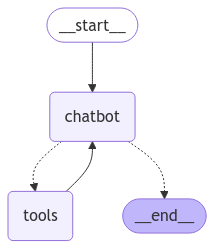

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: It seems like there is no input provided. How can I assist you today?
Assistant: 
Assistant: [{"url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph Platform. Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution to iterate quickly, debug immediately, and scale effortlessly.” LangGraph sets the foundation for how we can build and scale AI workloads — from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph Platform is a service for 